## 04 - Bulding a pipeline: Input/Output streams

So far, we have only dealt with single subject data. Oftentimes, however, we are dealing with data from multiple subjects and/or multiple runs. Thus, it would be nice to have an automated way to apply the workflow to all the files and store the output in an organized way. Luckily, Nipype comes with functions that handle such input/output stream.

This way, you can build your preprocessing/analysis pipeline for one subject, test it, and then process all subjects in an automated way.


#### Questions

- How can we apply our workflow to multiple subjects and runs?
- How can we stored the processed data in a clear structure?

#### Objective

- Setting up interface nodes handling input and output
- Learn how to incorporate sub-workflows

## Install dependencies and download data

In [1]:
import jupyter_black

jupyter_black.load()

In [2]:
import os
from nipype import Workflow, Node


fslpath = "/usr/local/fsl"
project_root_dir = os.getcwd()
os.environ["FSLOUTPUTTYPE"] = "NIFTI"
os.environ["FSLDIR"] = fslpath
os.environ["PATH"] += os.pathsep + os.path.join(fslpath, "bin")

os.makedirs("data", exist_ok=True)
os.makedirs("output/working_dir", exist_ok=True)
os.makedirs(fslpath + "/data/standard", exist_ok=True)

#!. ${FSLDIR}/etc/fslconf/fsl.sh
#!export FSLDIR PATH

In [3]:
# needed?
# os.environ["LD_LIBRARY_PATH"] = os.environ["LD_LIBRARY_PATH"] + os.pathsep + "/usr/lib/fsl/5.0"

In [4]:
data_dir = project_root_dir + "/data/ds000102"
output_dir = project_root_dir + "/output"

## Setup workflows

After everything has been installed, let's create a new (main) worklow:

In [7]:
wf = Workflow(name="test_workflow", base_dir="output/working_dir")

In our sample dataset we have three subject. Let's create a list of their IDs:

In [8]:
subject_list = ["sub-01", "sub-02", "sub-03"]

### Input/Output stream

For the input stream we will use the Nipype classes [```IdentityInterface```](https://nipype.readthedocs.io/en/0.12.1/interfaces/generated/nipype.interfaces.utility.html#index-3) and [```SelectFiles```](https://nipype.readthedocs.io/en/latest/api/generated/nipype.interfaces.io.html#selectfiles). For the output we will use the so called [```DataSink```](https://nipype.readthedocs.io/en/latest/api/generated/nipype.interfaces.io.html#datasink):

In [9]:
from nipype.interfaces.io import SelectFiles, DataSink
from nipype.interfaces.utility import IdentityInterface

With ```IdentityInterface``` we can iterate over a given list. In our case, this will be the subject list we have defined earlier. This will allow us to apply our workflow to all three subjects. Specifically, we set the ```fields``` parameter to ```"subject_id"``` (note that Nipype expects a list as input). The exact name here is arbitrary (you could also name it ```"sub"```). The important thing is that it matches the first element of the touple we provide to the ```iterables``` argument.

With this ```iterables``` argument, we basically tell Nipype "hey please iterate over every ```"subject_id"``` (or ```"sub"``` or whatever you may call it) you can find in ```subject_list```"

(Note that we place the interface within a Node so that we can include it in our workflow)

In [10]:
# iteration over all participants
infosource = Node(
    IdentityInterface(
        fields=["subject_id"]
    ),  # fields parameter needs to be a list, hence the brackets
    name="infosource",
)

infosource.iterables = [("subject_id", subject_list)]

```SelectFiles``` can be used to access the files of the respective subjects. Here, we have to specify a template, that matches the paths of the files we want to analyze - in our case, we provide the locations of both the functional and anatomical image. Note that ```subject_id``` is in curly brackets (this may be familar to you from Python's f strings) - this way, Nipype can iterative over the subject list and update the path in each iteration (importantly, the identifier string needs to match the one you passed to the ```fields``` parameter of the ```IdentitiyInterface```)

In [11]:
templates = {
    "anat": "{subject_id}/anat/{subject_id}_T1w.nii.gz",
    "func": "{subject_id}/func/{subject_id}_task-flanker_run-1_bold.nii.gz",
}

selectfiles = Node(
    SelectFiles(templates, base_directory=data_dir, sort_filelist=True),
    name="selectfiles",
)

To organize the output of our workflow, we will use Nipype's ```DataSink```. This is rather simple, we specify the the directory where we want to store the output folder (the name of the output folder is defined by the ```container``` parameter)

In [12]:
# Datasink/Output
datasink = Node(DataSink(base_directory=output_dir), name="datasink")

### Including a sub-workflow (or: "nested workflows")

Now that we have specified the input and output stream, we can define nodes to segment the participants' brains - just as we did last week. This time, however, we will create a second workflow (basically a **"workflow in a workflow"**). 

The main reason for this is clarity and comprehensibility: A complete preprocessing pipeline often includes a lot of different steps (or, in the world of Nipype: *Nodes*). Importantly, some steps can be logically grouped together (e.g., before segmenting the brain, one performs brain extraction in most cases). Thus, it makes sense for us to maintain this logic in our workflow. See [here](https://notebook.community/kdestasio/online_brain_intensive/nipype_tutorial/notebooks/basic_workflow) for a more detailed overview on workflows and specifically on nested workflows.

Let's create our first sub-workflow!

In [13]:
segment_wf = Workflow(name="segment_wf", base_dir="output/working_dir")

As we did last week, we have to setup Nodes for the brain extraction and segmentation. Note that other than in last week's notebook, we don't specify an input file for the brain extraction node - this will be handled by ```IdentityInterface```and ```SelectFiles```, respectively.

In [14]:
from nipype.interfaces.fsl import BET, FAST
from nipype import Node, Workflow

# Skullstrip Node
strip_skull = Node(BET(mask=True), name="strip_skull")

# Segmentation Node
segment = Node(FAST(), name="segment")

Now, let's connect the nodes of our sub-workflow. The only thing we need to do is specifying the brain extraction output as the input for the segmentation node (we don't need to care about input and output as this will be handled by our main workflow). 

In [15]:
segment_wf.connect([(strip_skull, segment, [("out_file", "in_files")])])

Next, let's tie all nodes together!
Unsurpringsingly, the first connection of our workflows handles the input. Specifically, we pass ```"subject_id"``` from ```IdentitiyInterface``` (remember the ```fields``` argument) to the ```SelectFiles``` node (now ```Selectfiles``` knows how to fill the template we have provided).

Afer speciying the input, it's time to include our segmentation sub-worfklow. To connect it to our main workflow, we need to change up the syntax a little bit. Specifically we need to include the sub-workflow's name in the call of the ```connect``` method. Thus,
```
(selectfiles, strip_skull, [("anat", "in_file")])
``` 
becomes 
``` 
(selectfiles, segment_wf,  [("anat", "strip_skull.in_file")] )
```

Let's put everything together!

In [16]:
wf.connect(
    [
        (infosource, selectfiles, [("subject_id", "subject_id")]),
        (selectfiles, segment_wf, [("anat", "strip_skull.in_file")]),
        (segment_wf, datasink, [("strip_skull.out_file", "datasink.@bet")]),
        (segment_wf, datasink, [("strip_skull.mask_file", "datasink.@bet_mask")]),
        (segment_wf, datasink, [("segment.partial_volume_files", "datasink.@segment")]),
    ]
)

221115-17:21:21,667 nipype.workflow INFO:
	 Generated workflow graph: output/working_dir/test_workflow/workflow_graph.png (graph2use=hierarchical, simple_form=True).


INFO:nipype.workflow:Generated workflow graph: output/working_dir/test_workflow/workflow_graph.png (graph2use=hierarchical, simple_form=True).


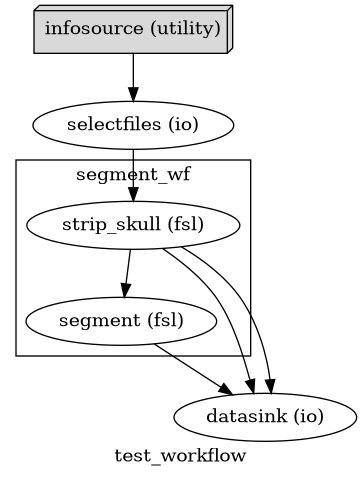

In [17]:
wf.write_graph("workflow_graph.dot")
from IPython.display import Image

Image(filename="output/working_dir/test_workflow/workflow_graph.png")

As you can see, we have succesfully included a sub-workflow in our routine. In fact, Nipype comes with a few already pre-defined workflows - check them out [here](https://nipype.readthedocs.io/en/1.1.7/interfaces/generated/workflows.fmri.html).

In [18]:
wf.run("MultiProc", plugin_args={"n_procs": 8})

221115-17:21:22,211 nipype.workflow INFO:
	 Workflow test_workflow settings: ['check', 'execution', 'logging', 'monitoring']


INFO:nipype.workflow:Workflow test_workflow settings: ['check', 'execution', 'logging', 'monitoring']


221115-17:21:22,226 nipype.workflow INFO:
	 Running in parallel.


INFO:nipype.workflow:Running in parallel.


221115-17:21:22,229 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 3 jobs ready. Free memory (GB): 13.85/13.85, Free processors: 8/8.


INFO:nipype.workflow:[MultiProc] Running 0 tasks, and 3 jobs ready. Free memory (GB): 13.85/13.85, Free processors: 8/8.


221115-17:21:22,400 nipype.workflow INFO:
	 [Node] Setting-up "test_workflow.selectfiles" in "/home/user/data/psy_misc/tewa2-neuroimaging/output/working_dir/test_workflow/_subject_id_sub-01/selectfiles".
221115-17:21:22,402 nipype.workflow INFO:
	 [Node] Setting-up "test_workflow.selectfiles" in "/home/user/data/psy_misc/tewa2-neuroimaging/output/working_dir/test_workflow/_subject_id_sub-02/selectfiles".


INFO:nipype.workflow:[Node] Setting-up "test_workflow.selectfiles" in "/home/user/data/psy_misc/tewa2-neuroimaging/output/working_dir/test_workflow/_subject_id_sub-01/selectfiles".


221115-17:21:22,403 nipype.workflow INFO:
	 [Node] Setting-up "test_workflow.selectfiles" in "/home/user/data/psy_misc/tewa2-neuroimaging/output/working_dir/test_workflow/_subject_id_sub-03/selectfiles".


INFO:nipype.workflow:[Node] Setting-up "test_workflow.selectfiles" in "/home/user/data/psy_misc/tewa2-neuroimaging/output/working_dir/test_workflow/_subject_id_sub-02/selectfiles".
INFO:nipype.workflow:[Node] Setting-up "test_workflow.selectfiles" in "/home/user/data/psy_misc/tewa2-neuroimaging/output/working_dir/test_workflow/_subject_id_sub-03/selectfiles".


221115-17:21:22,410 nipype.workflow INFO:
	 [Node] Executing "selectfiles" <nipype.interfaces.io.SelectFiles>
221115-17:21:22,411 nipype.workflow INFO:
	 [Node] Executing "selectfiles" <nipype.interfaces.io.SelectFiles>
221115-17:21:22,412 nipype.workflow INFO:
	 [Node] Executing "selectfiles" <nipype.interfaces.io.SelectFiles>


INFO:nipype.workflow:[Node] Executing "selectfiles" <nipype.interfaces.io.SelectFiles>
INFO:nipype.workflow:[Node] Executing "selectfiles" <nipype.interfaces.io.SelectFiles>
INFO:nipype.workflow:[Node] Executing "selectfiles" <nipype.interfaces.io.SelectFiles>


221115-17:21:22,420 nipype.workflow INFO:
	 [Node] Finished "selectfiles", elapsed time 0.001634s.
221115-17:21:22,419 nipype.workflow INFO:
	 [Node] Finished "selectfiles", elapsed time 0.001651s.
221115-17:21:22,420 nipype.workflow INFO:
	 [Node] Finished "selectfiles", elapsed time 0.001511s.


INFO:nipype.workflow:[Node] Finished "selectfiles", elapsed time 0.001511s.
INFO:nipype.workflow:[Node] Finished "selectfiles", elapsed time 0.001634s.
INFO:nipype.workflow:[Node] Finished "selectfiles", elapsed time 0.001651s.


221115-17:21:24,234 nipype.workflow INFO:
	 [Job 0] Completed (test_workflow.selectfiles).


INFO:nipype.workflow:[Job 0] Completed (test_workflow.selectfiles).


221115-17:21:24,248 nipype.workflow INFO:
	 [Job 1] Completed (test_workflow.selectfiles).


INFO:nipype.workflow:[Job 1] Completed (test_workflow.selectfiles).


221115-17:21:24,257 nipype.workflow INFO:
	 [Job 2] Completed (test_workflow.selectfiles).


INFO:nipype.workflow:[Job 2] Completed (test_workflow.selectfiles).


221115-17:21:24,264 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 3 jobs ready. Free memory (GB): 13.85/13.85, Free processors: 8/8.


INFO:nipype.workflow:[MultiProc] Running 0 tasks, and 3 jobs ready. Free memory (GB): 13.85/13.85, Free processors: 8/8.


221115-17:21:24,390 nipype.workflow INFO:
	 [Job 3] Cached (test_workflow.segment_wf.strip_skull).


INFO:nipype.workflow:[Job 3] Cached (test_workflow.segment_wf.strip_skull).


221115-17:21:24,396 nipype.workflow INFO:
	 [Job 4] Cached (test_workflow.segment_wf.strip_skull).


INFO:nipype.workflow:[Job 4] Cached (test_workflow.segment_wf.strip_skull).


221115-17:21:24,401 nipype.workflow INFO:
	 [Job 5] Cached (test_workflow.segment_wf.strip_skull).


INFO:nipype.workflow:[Job 5] Cached (test_workflow.segment_wf.strip_skull).


221115-17:21:26,336 nipype.workflow INFO:
	 [Job 6] Cached (test_workflow.segment_wf.segment).


INFO:nipype.workflow:[Job 6] Cached (test_workflow.segment_wf.segment).


221115-17:21:26,342 nipype.workflow INFO:
	 [Job 7] Cached (test_workflow.segment_wf.segment).


INFO:nipype.workflow:[Job 7] Cached (test_workflow.segment_wf.segment).


221115-17:21:26,348 nipype.workflow INFO:
	 [Job 8] Cached (test_workflow.segment_wf.segment).


INFO:nipype.workflow:[Job 8] Cached (test_workflow.segment_wf.segment).


221115-17:21:28,329 nipype.workflow INFO:
	 [Node] Setting-up "test_workflow.datasink" in "/home/user/data/psy_misc/tewa2-neuroimaging/output/working_dir/test_workflow/_subject_id_sub-01/datasink".
221115-17:21:28,332 nipype.workflow INFO:
	 [Node] Setting-up "test_workflow.datasink" in "/home/user/data/psy_misc/tewa2-neuroimaging/output/working_dir/test_workflow/_subject_id_sub-02/datasink".


INFO:nipype.workflow:[Node] Setting-up "test_workflow.datasink" in "/home/user/data/psy_misc/tewa2-neuroimaging/output/working_dir/test_workflow/_subject_id_sub-01/datasink".


221115-17:21:28,332 nipype.workflow INFO:
	 [Node] Setting-up "test_workflow.datasink" in "/home/user/data/psy_misc/tewa2-neuroimaging/output/working_dir/test_workflow/_subject_id_sub-03/datasink".


INFO:nipype.workflow:[Node] Setting-up "test_workflow.datasink" in "/home/user/data/psy_misc/tewa2-neuroimaging/output/working_dir/test_workflow/_subject_id_sub-02/datasink".
INFO:nipype.workflow:[Node] Setting-up "test_workflow.datasink" in "/home/user/data/psy_misc/tewa2-neuroimaging/output/working_dir/test_workflow/_subject_id_sub-03/datasink".


221115-17:21:28,346 nipype.workflow INFO:
	 [Node] Executing "datasink" <nipype.interfaces.io.DataSink>


INFO:nipype.workflow:[Node] Executing "datasink" <nipype.interfaces.io.DataSink>


221115-17:21:28,347 nipype.workflow INFO:
	 [Node] Executing "datasink" <nipype.interfaces.io.DataSink>


INFO:nipype.workflow:[Node] Executing "datasink" <nipype.interfaces.io.DataSink>


221115-17:21:28,351 nipype.workflow INFO:
	 [Node] Executing "datasink" <nipype.interfaces.io.DataSink>


INFO:nipype.workflow:[Node] Executing "datasink" <nipype.interfaces.io.DataSink>


221115-17:21:28,353 nipype.workflow INFO:
	 [Node] Finished "datasink", elapsed time 0.002467s.


INFO:nipype.workflow:[Node] Finished "datasink", elapsed time 0.002467s.


221115-17:21:28,355 nipype.workflow INFO:
	 [Node] Finished "datasink", elapsed time 0.002554s.


INFO:nipype.workflow:[Node] Finished "datasink", elapsed time 0.002554s.


221115-17:21:28,359 nipype.workflow INFO:
	 [Node] Finished "datasink", elapsed time 0.002367s.


INFO:nipype.workflow:[Node] Finished "datasink", elapsed time 0.002367s.


221115-17:21:30,236 nipype.workflow INFO:
	 [Job 9] Completed (test_workflow.datasink).


INFO:nipype.workflow:[Job 9] Completed (test_workflow.datasink).


221115-17:21:30,238 nipype.workflow INFO:
	 [Job 10] Completed (test_workflow.datasink).


INFO:nipype.workflow:[Job 10] Completed (test_workflow.datasink).


221115-17:21:30,240 nipype.workflow INFO:
	 [Job 11] Completed (test_workflow.datasink).


INFO:nipype.workflow:[Job 11] Completed (test_workflow.datasink).


221115-17:21:30,244 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 0 jobs ready. Free memory (GB): 13.85/13.85, Free processors: 8/8.


INFO:nipype.workflow:[MultiProc] Running 0 tasks, and 0 jobs ready. Free memory (GB): 13.85/13.85, Free processors: 8/8.


Let's check our results. We will every subject's extracted brain, overlayed with contours of their grey matter:

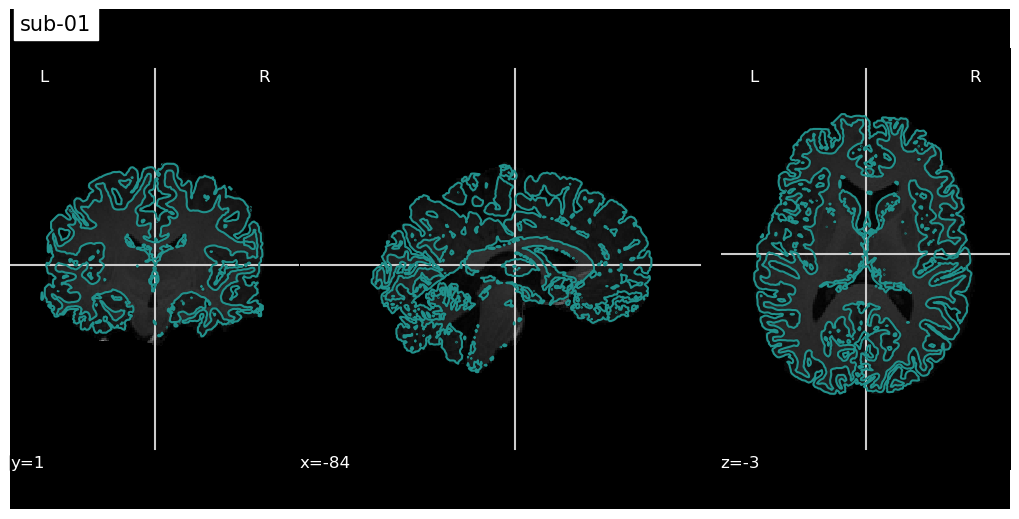

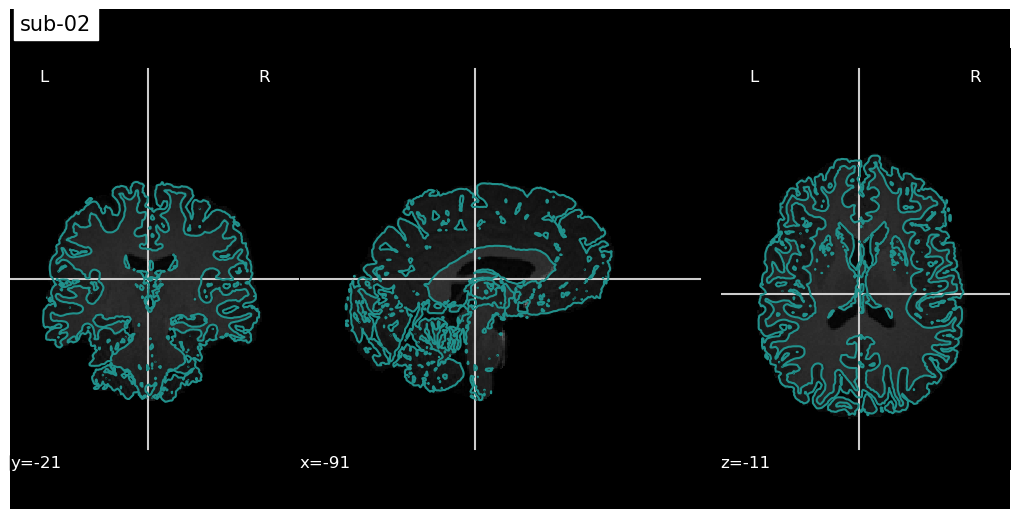

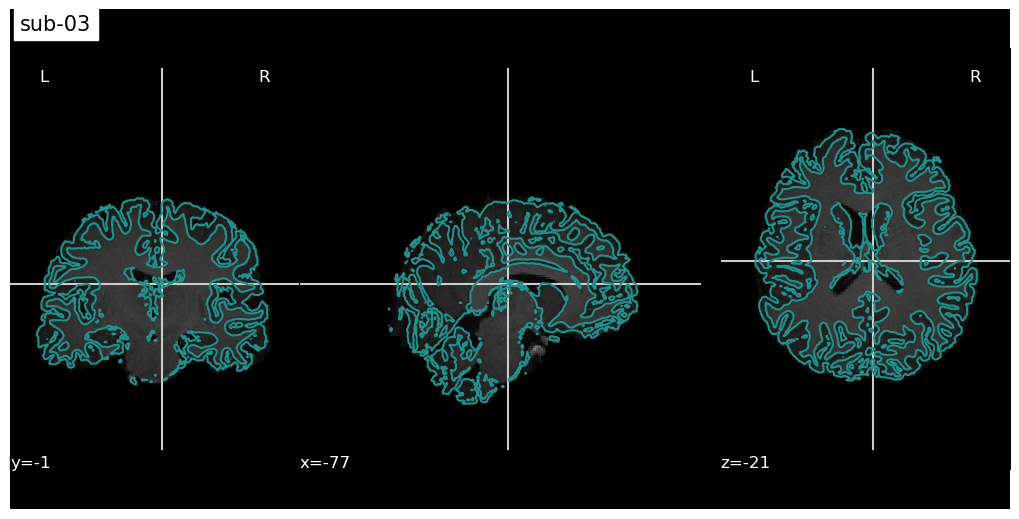

In [37]:
from nilearn import plotting
import matplotlib.pyplot as plt

for subject in subject_list:

    exracted_brain = (
        output_dir + f"/datasink/_subject_id_{subject}/{subject}_T1w_brain.nii"
    )
    grey_matter = (
        output_dir + f"/datasink/_subject_id_{subject}/{subject}_T1w_brain_pve_1.nii"
    )

    fig = plt.figure(figsize=(10, 5))

    disp = plotting.plot_anat(exracted_brain, title=subject, figure=fig)
    disp.add_contours(grey_matter, levels=[0.5])

## Exercise

In this notebook we learned how to apply Nipype workflows to multiple subjects and/or runs. Also, we learned how to construct workflows inside workflows. In this exercise your task is to include the two nodes you created in the last exercise (i.e., Realignment and Slicetiming correction). This will get us closer to our final pipeline! The exact steps are:

- Define main worfklow (see above)
- Setup Realignment and slicetime correction nodes (see last week's exercise)
- Connect all nodes


In [38]:
# we delete the main workflow object so that you can form new connections
del wf

## Resources

[Nipype Tutorial: Data Input](https://miykael.github.io/nipype_tutorial/notebooks/basic_data_input.html)

[Nipype Tutorial: Data Output](https://miykael.github.io/nipype_tutorial/notebooks/basic_data_output.html)